In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from feature_engine.selection import DropCorrelatedFeatures
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import utils
from utils import pct_change, draw_pct_change, draw_time_series_for_all_engines

In [80]:
OUTLIER_RUL_THRESHOLD = 280
CORRELATION_THRESHOLD = 0.7
ENGINE_ID = 1
ROLLING_AVERAGE_WINDOW = 5
df = utils.load_data("CMAPSSData/train_FD001.txt")
df.describe()

,engine_id,time,operational_setting_1,operational_setting_2,operational_setting_3,Fan_inlet_temperature,LPC_outlet_temperature,HPC_outlet_temperature,LPT_outlet_temperature,Fan_inlet_Pressure,...,Ratio_of_fuel_flow_to_Ps30,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Burner_fuel-air_ratio,Bleed_Enthalpy,Required_fan_speed,Required_fan_conversion_speed,High-pressure_turbines_Cool_air_flow,Low-pressure_turbines_Cool_air_flow
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [81]:
df.nunique()

engine_id                                100
time                                     362
operational_setting_1                    158
operational_setting_2                     13
operational_setting_3                      1
Fan_inlet_temperature                      1
LPC_outlet_temperature                   310
HPC_outlet_temperature                  3012
LPT_outlet_temperature                  4051
Fan_inlet_Pressure                         1
bypass-duct_pressure                       2
HPC_outlet_pressure                      513
Physical_fan_speed                        53
Physical_core_speed                     6403
Engine_pressure_ratio(                     1
HPC_outlet_Static_pressure               159
Ratio_of_fuel_flow_to_Ps30               427
Corrected_fan_speed                       56
Corrected_core_speed                    6078
Bypass_Ratio                            1918
Burner_fuel-air_ratio                      1
Bleed_Enthalpy                            13
Required_f

## drop constant or nearly constant columns

In [82]:
# df = df.loc[:, df.nunique() > 13]

### Max cycles histogram


<Axes: >

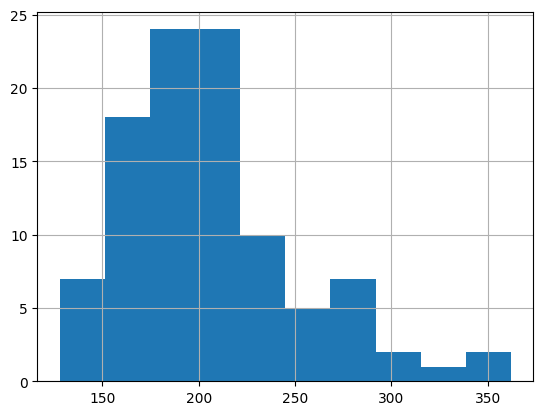

In [83]:
df.groupby(["engine_id"])["time"].max().hist()

### Drop outliers

<Axes: >

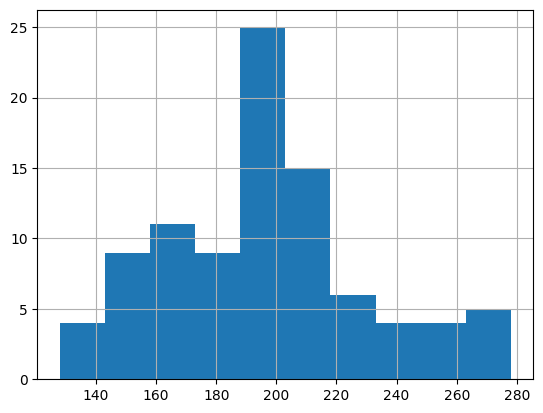

In [84]:
ids_to_drop = df.loc[df['time'] > OUTLIER_RUL_THRESHOLD, 'engine_id'].unique()
df = df[~df['engine_id'].isin(ids_to_drop)]
df.groupby(["engine_id"])["time"].max().hist()

In [85]:
features = list(df.columns)
features.remove('time')
features.remove('engine_id')
y = df.groupby('engine_id')['time'].transform('max') - df['time']
features_df = df[features]
features_df

,operational_setting_1,operational_setting_2,operational_setting_3,Fan_inlet_temperature,LPC_outlet_temperature,HPC_outlet_temperature,LPT_outlet_temperature,Fan_inlet_Pressure,bypass-duct_pressure,HPC_outlet_pressure,...,Ratio_of_fuel_flow_to_Ps30,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Burner_fuel-air_ratio,Bleed_Enthalpy,Required_fan_speed,Required_fan_conversion_speed,High-pressure_turbines_Cool_air_flow,Low-pressure_turbines_Cool_air_flow
0,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [86]:

f_scores, p_values = f_regression(features_df, y)
threshold = 0.05
significant_features = features_df.columns[p_values < threshold]
dropped_features = features_df.columns[p_values >= threshold]
df_filtered = df[significant_features]

print("Selected Features:")
print(significant_features)
print("Dropped features:")
print(dropped_features)
df = pd.merge(df[['time', 'engine_id']], df_filtered, left_index=True, right_index=True)

Selected Features:
Index(['LPC_outlet_temperature', 'HPC_outlet_temperature',
       'LPT_outlet_temperature', 'bypass-duct_pressure', 'HPC_outlet_pressure',
       'Physical_fan_speed', 'Physical_core_speed',
       'HPC_outlet_Static_pressure', 'Ratio_of_fuel_flow_to_Ps30',
       'Corrected_fan_speed', 'Corrected_core_speed', 'Bypass_Ratio',
       'Bleed_Enthalpy', 'High-pressure_turbines_Cool_air_flow',
       'Low-pressure_turbines_Cool_air_flow'],
      dtype='object')
Dropped features:
Index(['operational_setting_1', 'operational_setting_2',
       'operational_setting_3', 'Fan_inlet_temperature', 'Fan_inlet_Pressure',
       'Engine_pressure_ratio(', 'Burner_fuel-air_ratio', 'Required_fan_speed',
       'Required_fan_conversion_speed'],
      dtype='object')


/Users/pszmurlo/Documents/pw/PBAD1/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:379: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) - n_samples * X_means**2)


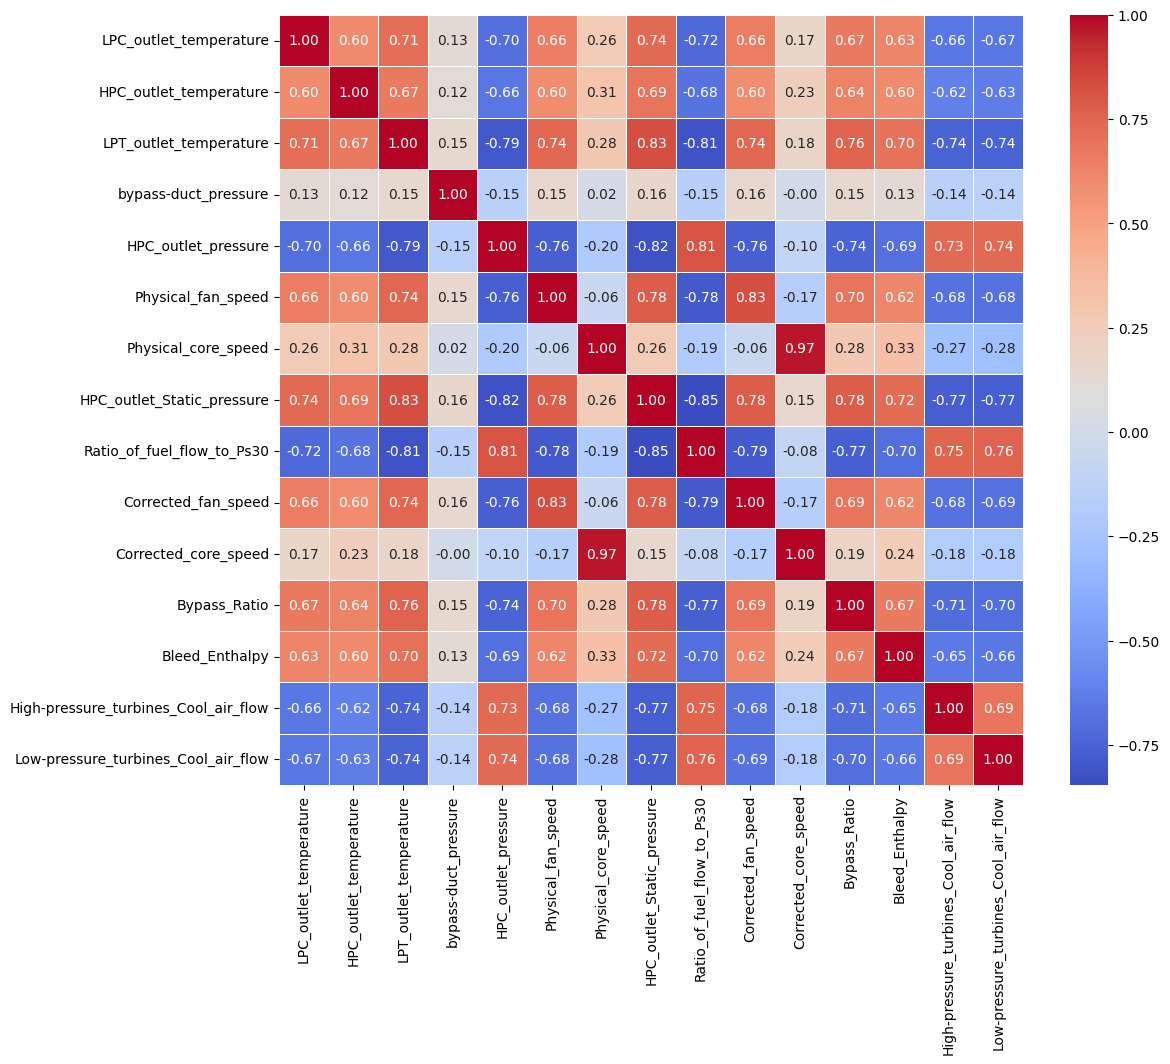

In [87]:
utils.draw_corr(df[significant_features])

In [88]:
features_df = df.drop(['time', 'engine_id'], axis=1)
dcf = DropCorrelatedFeatures(threshold=CORRELATION_THRESHOLD)
features_df = dcf.fit_transform(features_df)
df = pd.merge(df[['engine_id', 'time']], features_df, left_index=True, right_index=True)
df.columns

Index(['engine_id', 'time', 'LPC_outlet_temperature', 'HPC_outlet_temperature',
       'bypass-duct_pressure', 'Corrected_fan_speed', 'Corrected_core_speed',
       'Bypass_Ratio', 'Bleed_Enthalpy'],
      dtype='object')

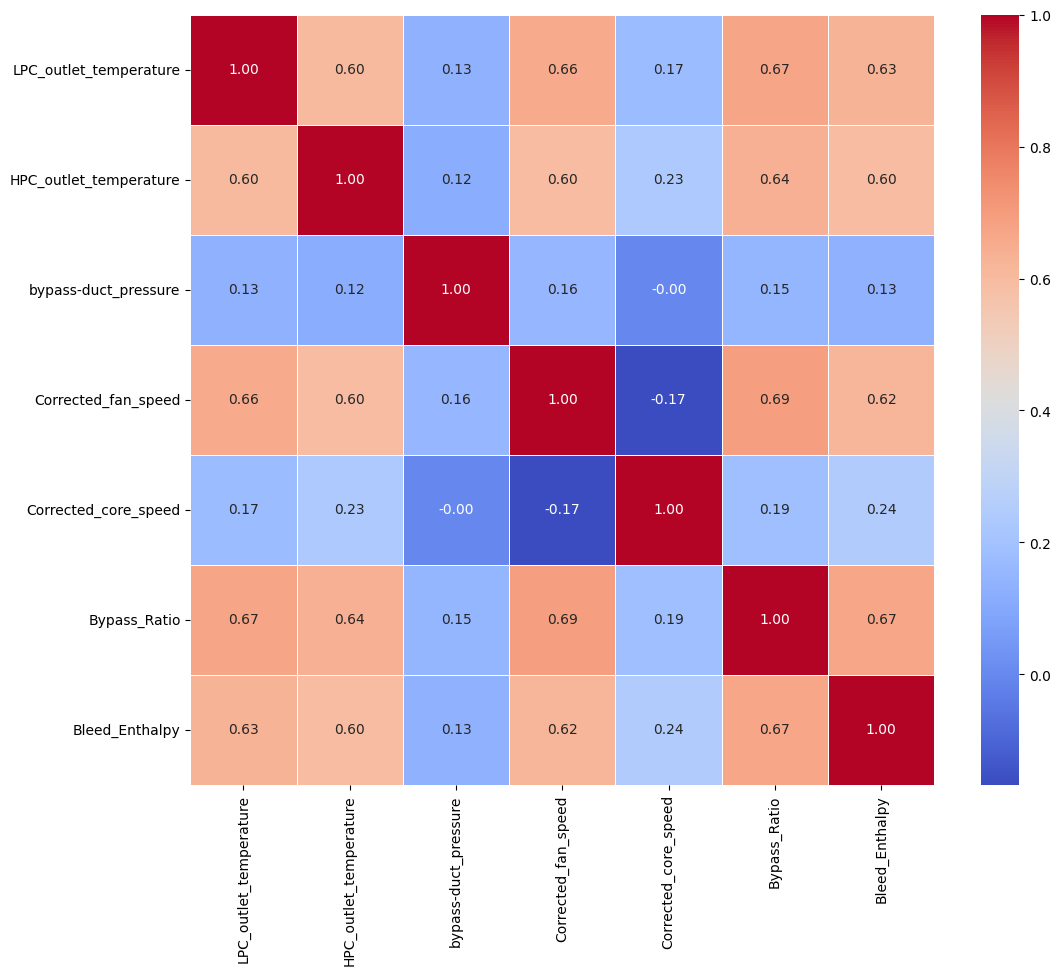

In [89]:
utils.draw_corr(features_df)

In [90]:
scaler = MinMaxScaler()
cols = df.columns[df.columns != "engine_id"]
cols = cols[cols != "time"]
cols = cols[cols != "rul"]
df[cols] = scaler.fit_transform(df[cols])
df.describe()
# df = df.drop(["bypass-duct_pressure"], axis=1)

,engine_id,time,LPC_outlet_temperature,HPC_outlet_temperature,bypass-duct_pressure,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy
count,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000,18133.000000
mean,48.704848,102.038990,0.446281,0.426822,0.981139,0.320605,0.226014,0.454134,0.436805
std,28.276056,61.987076,0.149716,0.133175,0.136037,0.106545,0.102807,0.143620,0.128648
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,50.000000,0.340361,0.334205,1.000000,0.250000,0.167252,0.350519,0.333333
50%,48.000000,99.000000,0.436747,0.418138,1.000000,0.323529,0.208845,0.442863,0.416667
75%,74.000000,149.000000,0.542169,0.511227,1.000000,0.382353,0.250026,0.543671,0.500000
max,100.000000,278.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Index(['engine_id', 'time', 'LPC_outlet_temperature', 'HPC_outlet_temperature',
       'bypass-duct_pressure', 'Corrected_fan_speed', 'Corrected_core_speed',
       'Bypass_Ratio', 'Bleed_Enthalpy', 'LPC_outlet_temperature rolling',
       'HPC_outlet_temperature rolling', 'bypass-duct_pressure rolling',
       'Corrected_fan_speed rolling', 'Corrected_core_speed rolling',
       'Bypass_Ratio rolling', 'Bleed_Enthalpy rolling'],
      dtype='object')


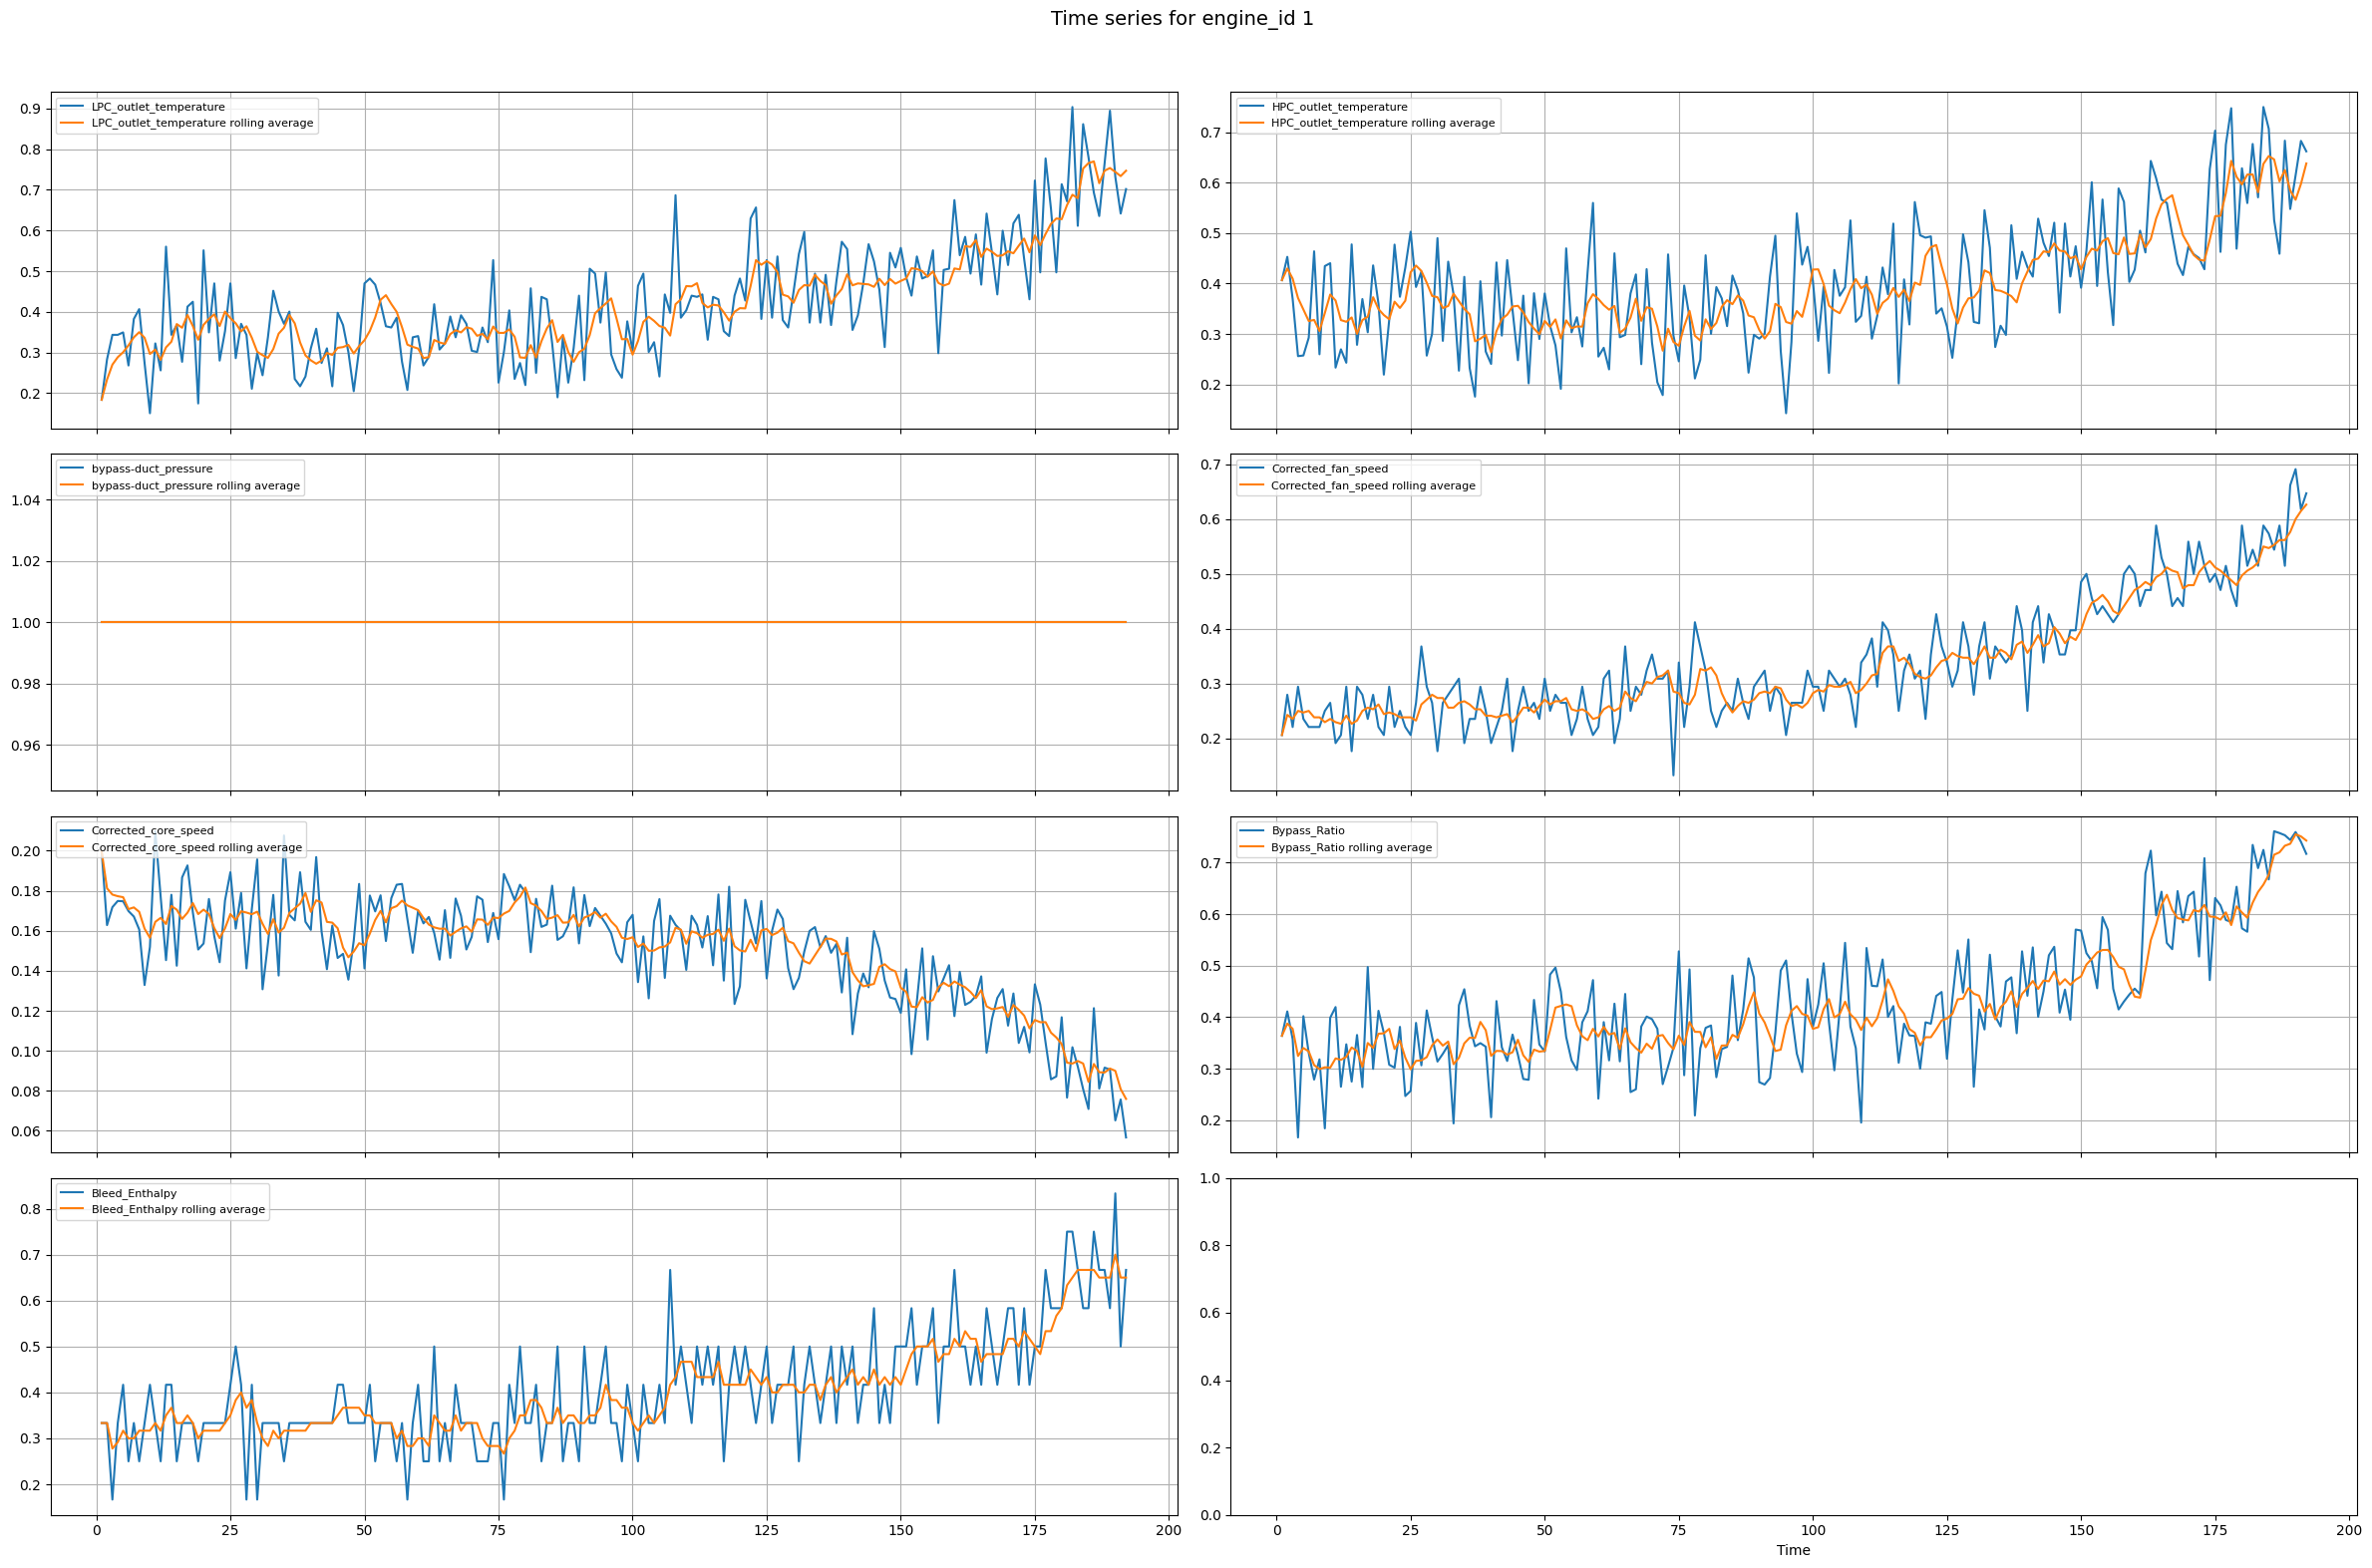

In [91]:
utils.draw_time_series(df.copy(), ENGINE_ID, ROLLING_AVERAGE_WINDOW)
# df['rul'] = df.groupby('engine_id')['time'].transform('max') - df['time']

# X_train, X_test, y_train, y_test = train_test_split(df_train, df_train['rul'], test_size=0.3, random_state=42)

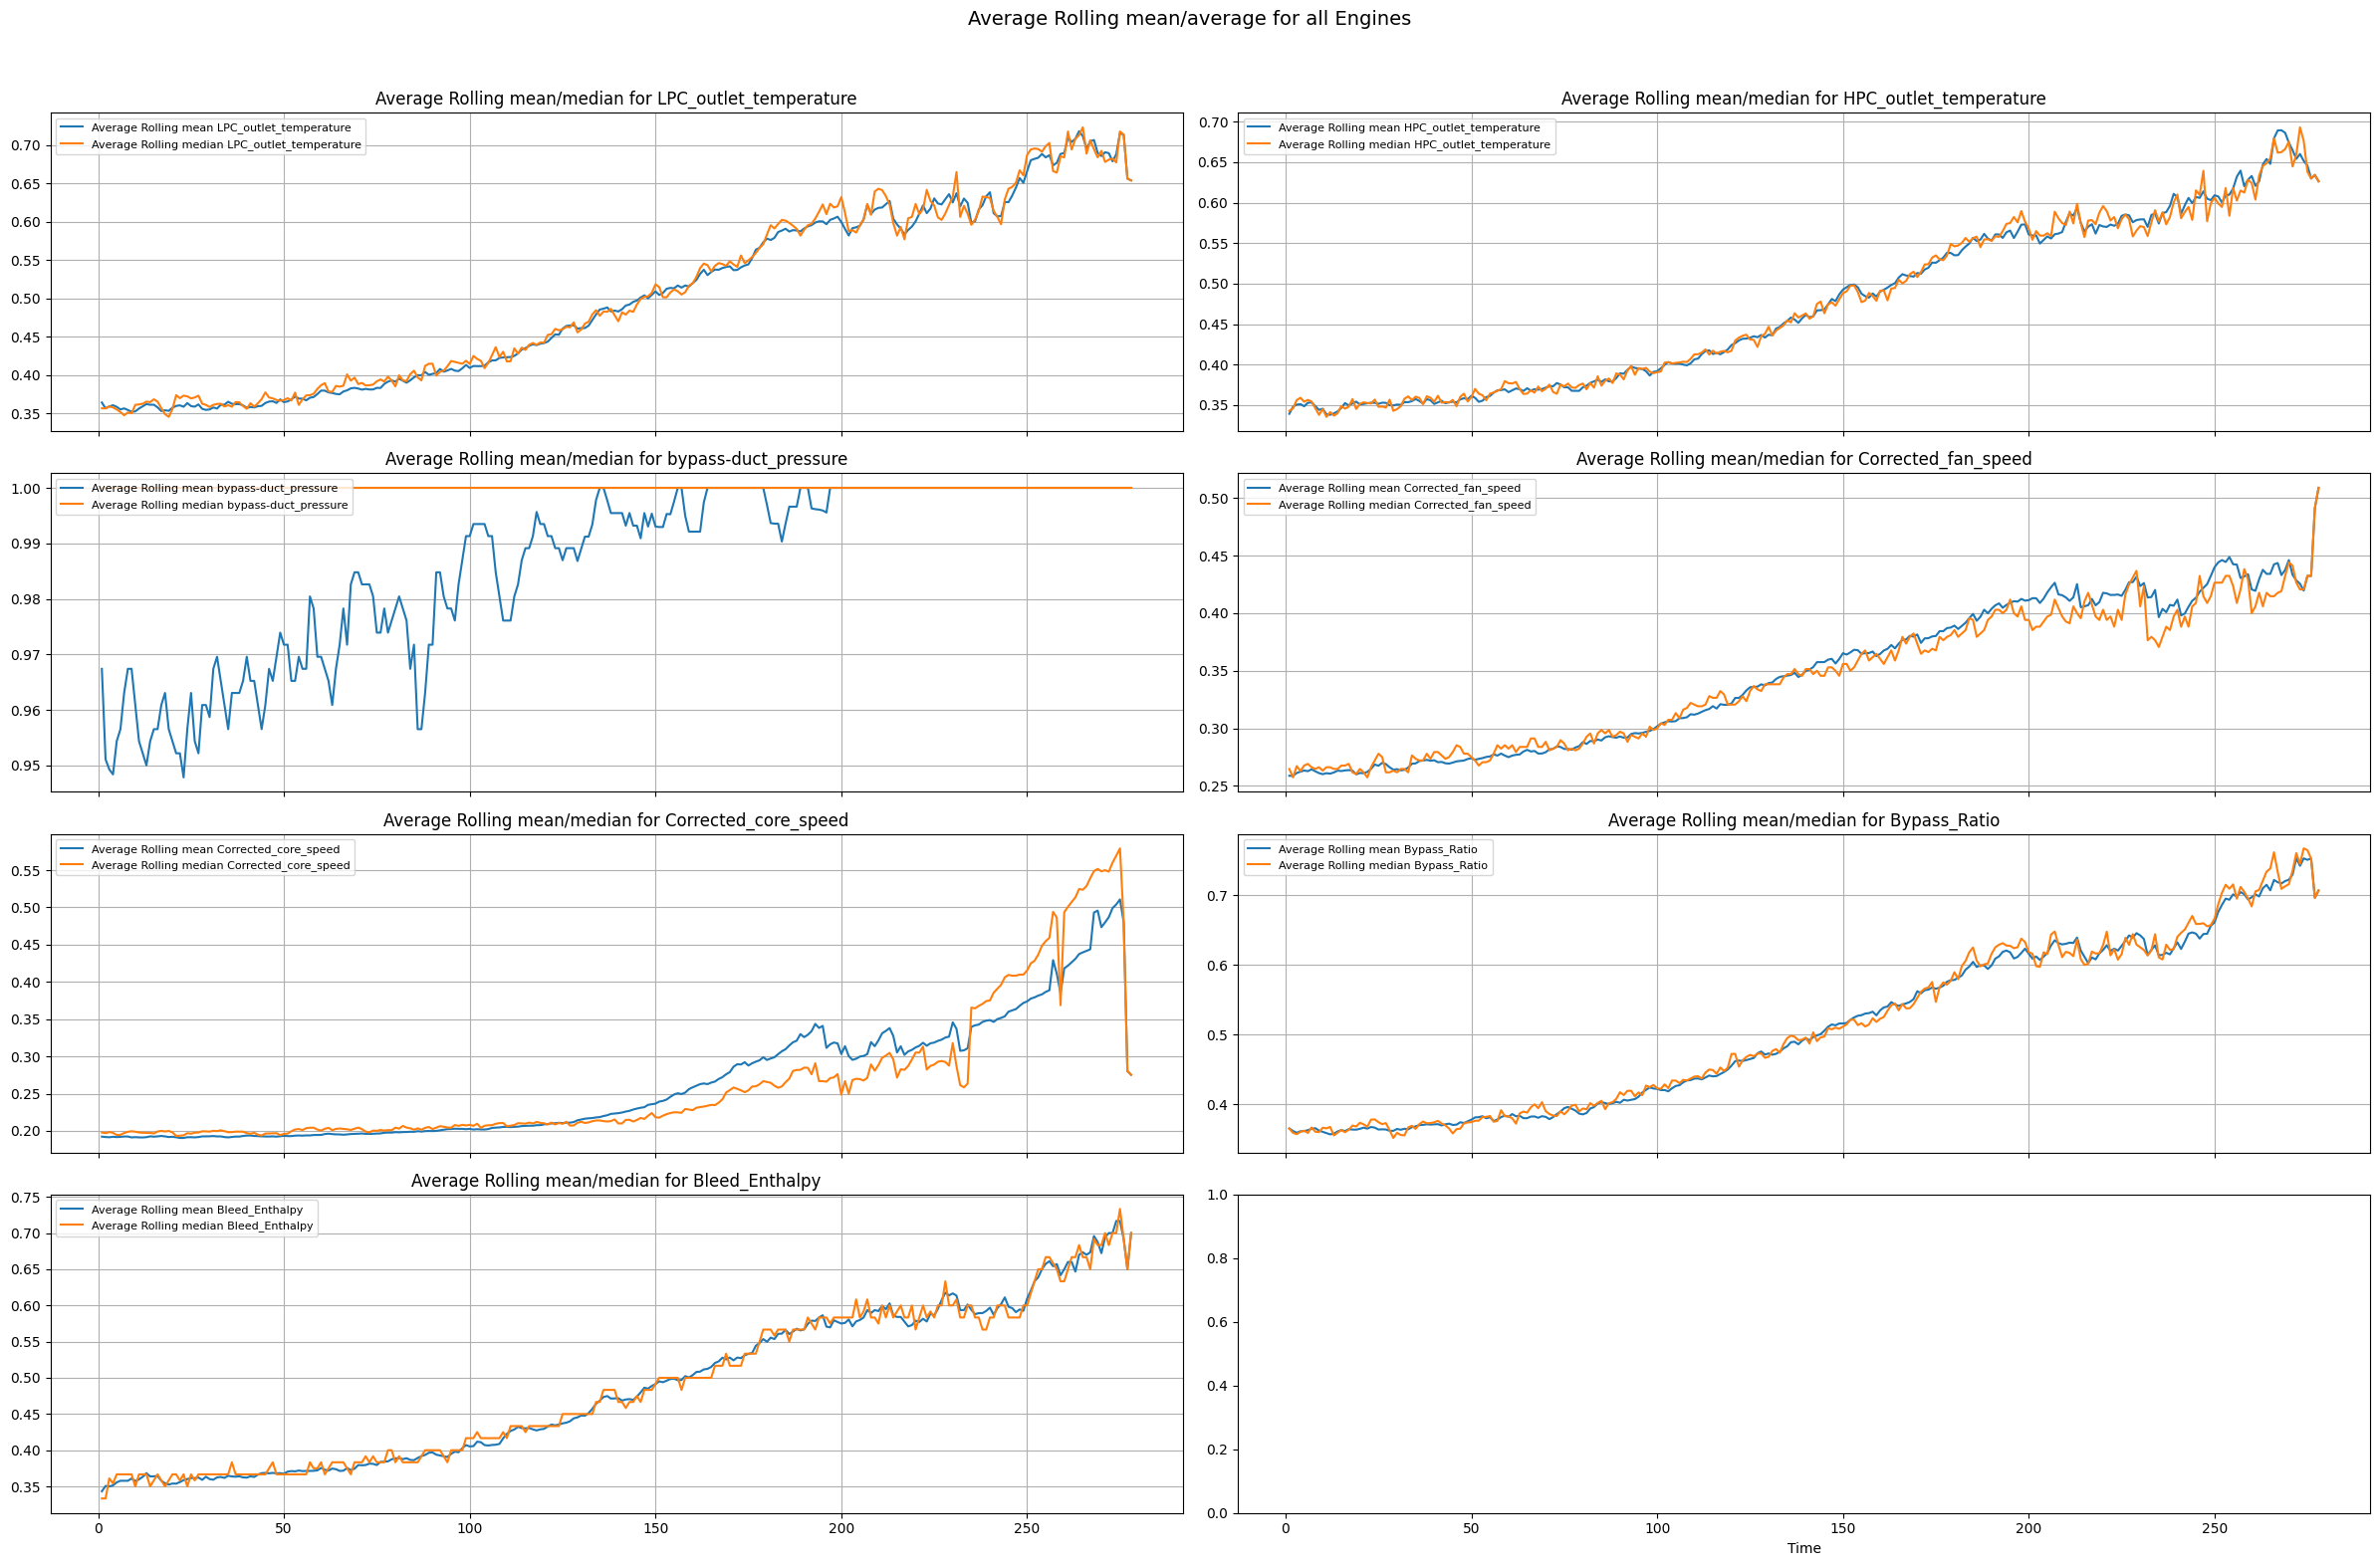

In [92]:
draw_time_series_for_all_engines(df, ROLLING_AVERAGE_WINDOW)

In [93]:
df

,engine_id,time,LPC_outlet_temperature,HPC_outlet_temperature,bypass-duct_pressure,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy
0,1,1,0.183735,0.406802,1.0,0.205882,0.199608,0.363986,0.333333
1,1,2,0.283133,0.453019,1.0,0.279412,0.162813,0.411312,0.333333
2,1,3,0.343373,0.369523,1.0,0.220588,0.171793,0.357445,0.166667
3,1,4,0.343373,0.256159,1.0,0.294118,0.174889,0.166603,0.333333
4,1,5,0.349398,0.257467,1.0,0.235294,0.174734,0.402078,0.416667
...,...,...,...,...,...,...,...,...,...
20626,100,196,0.686747,0.587312,1.0,0.558824,0.194344,0.656791,0.750000
20627,100,197,0.701807,0.729453,1.0,0.500000,0.188668,0.727203,0.583333
20628,100,198,0.665663,0.684979,1.0,0.529412,0.212148,0.922278,0.833333
20629,100,199,0.608434,0.746021,1.0,0.514706,0.203065,0.823394,0.583333


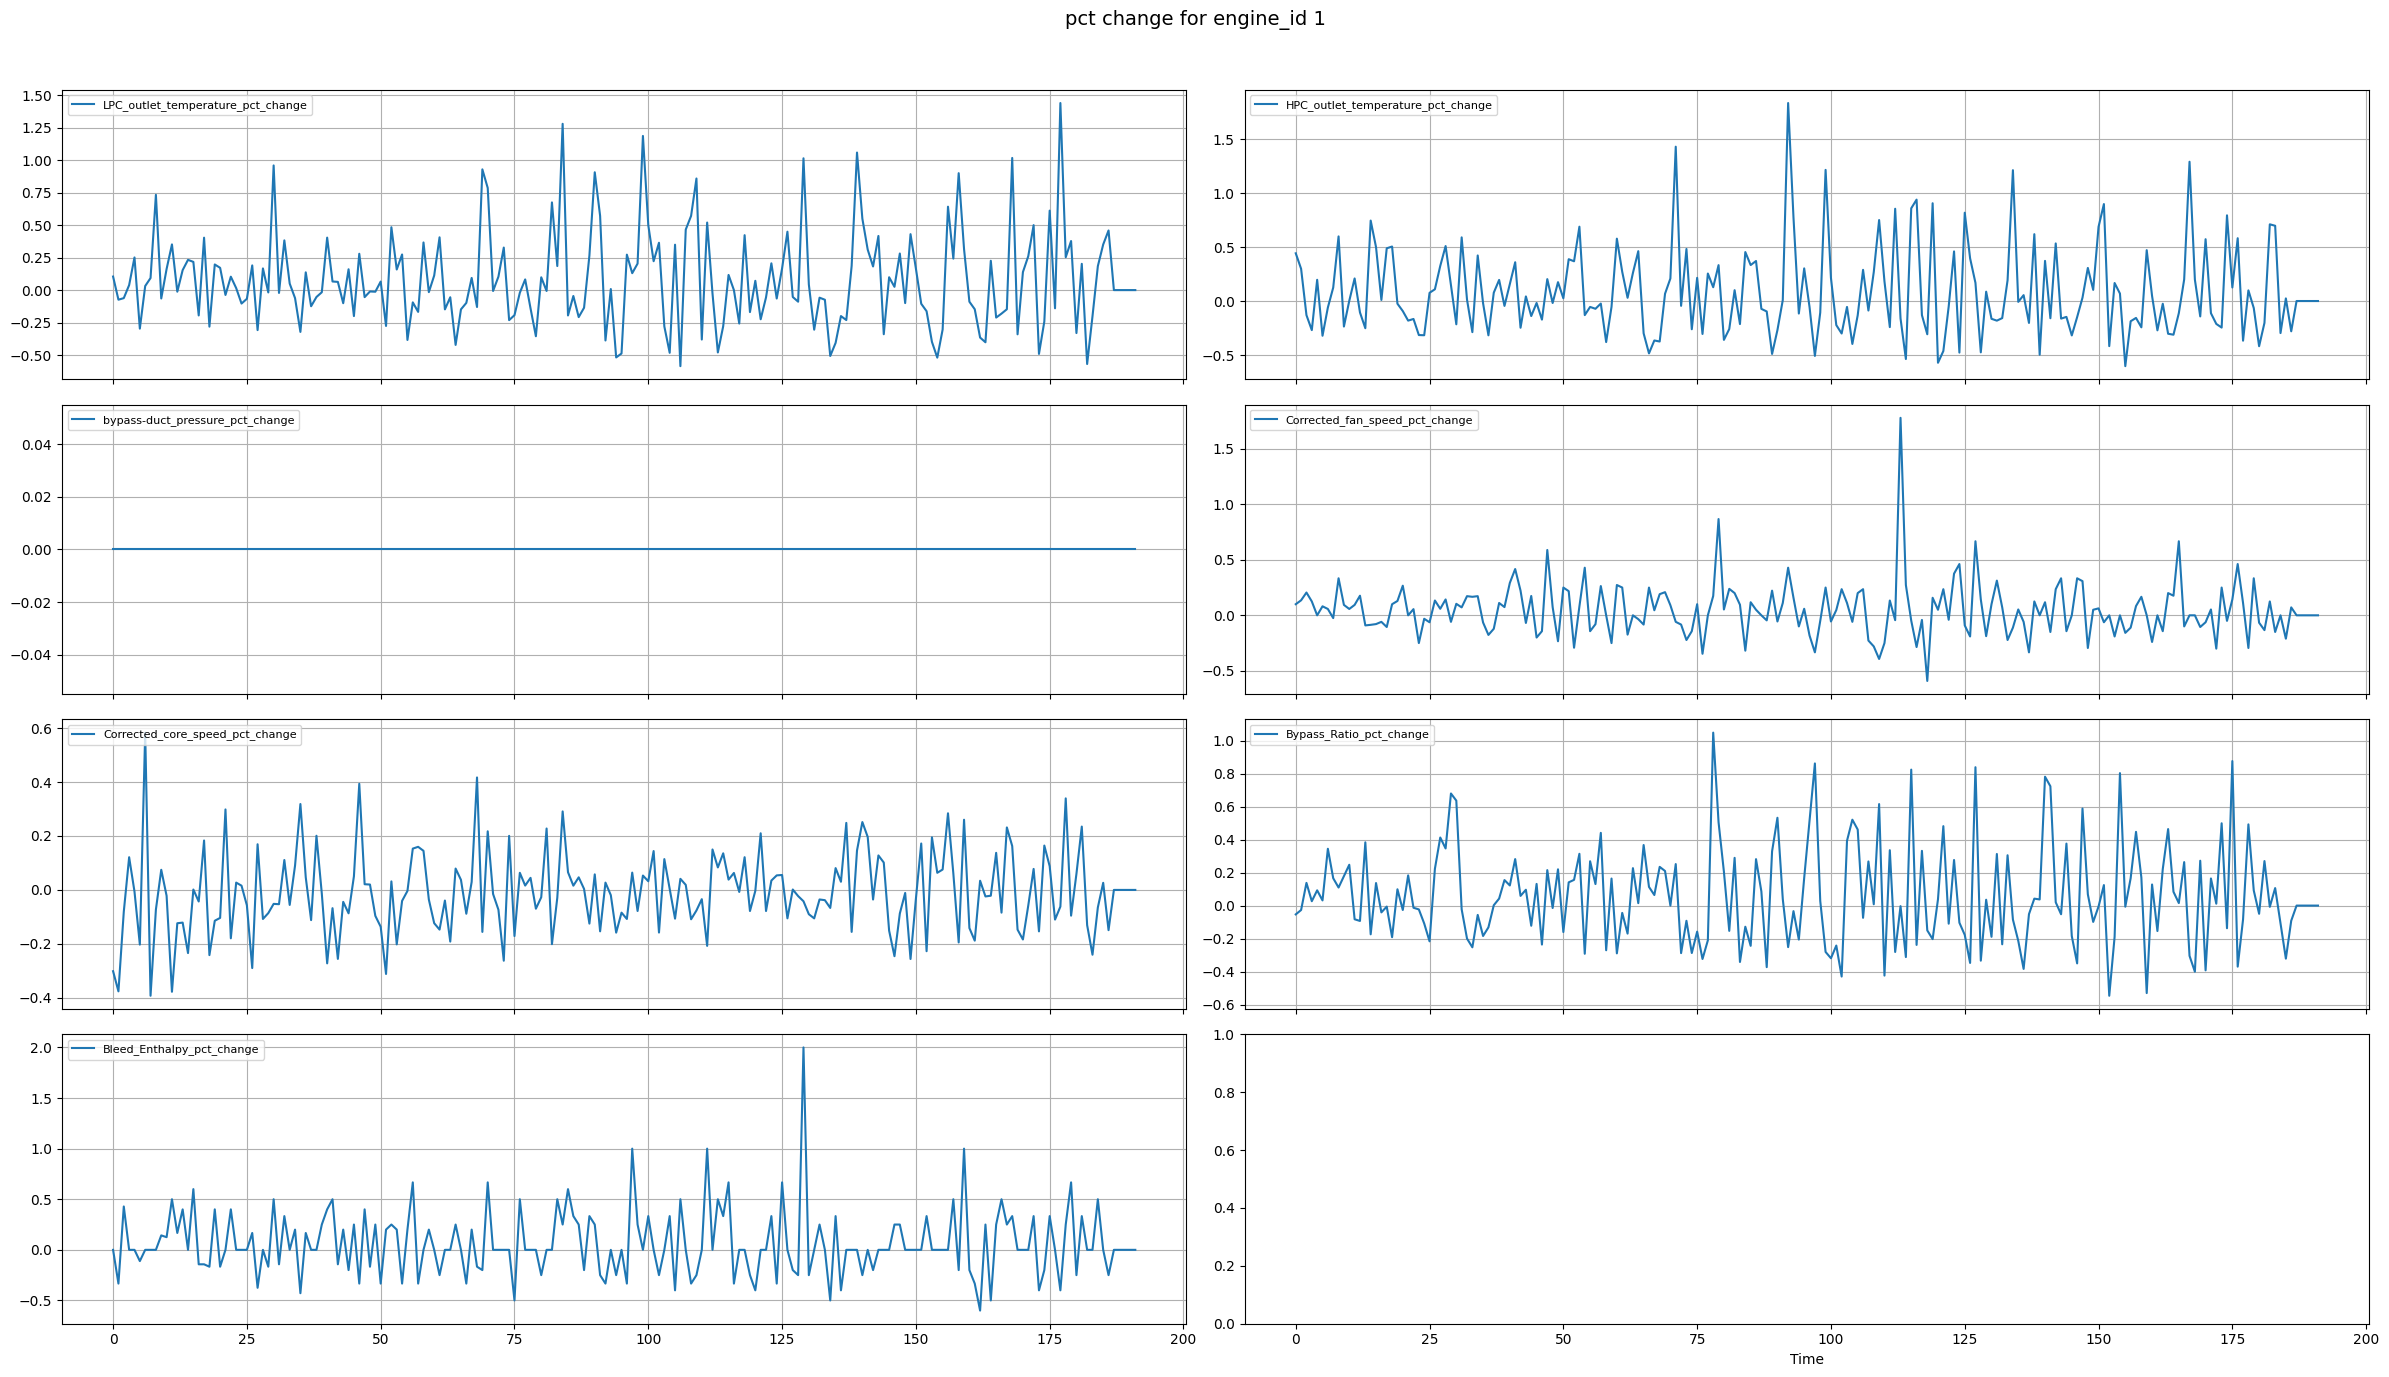

In [94]:
features = list(df.columns)
features.remove('time')
features.remove('engine_id')
df_with_pctchange = pct_change(df, features)
df_with_pctchange['rul'] = df.groupby('engine_id')['time'].transform('max') - df['time']
draw_pct_change(df_with_pctchange, ENGINE_ID)

In [95]:
features = list(df.columns)
features.remove('engine_id')
y = df.groupby('engine_id')['time'].transform('max') - df['time']
X = df[features]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [98]:
y_pred

array([ 70.26518647, 142.53507129,   0.39403513, ...,  67.79952246,
       119.96659124,  11.81083588])

In [99]:
y_test

14679     84
2414     131
6608       3
17452    165
3973     194
        ... 
20052     37
9859      49
5608      21
9152     112
16575     16
Name: time, Length: 3627, dtype: int64

In [100]:
from sklearn.metrics import r2_score, mean_squared_error


def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))


evaluate(y_test, y_pred)

test set RMSE:30.672292460821094, R2:0.7555620880724823


In [101]:
y_test - y_pred

14679    13.734814
2414    -11.535071
6608      2.605965
17452    68.400892
3973     46.644329
           ...    
20052   -25.211480
9859    -21.121099
5608    -46.799522
9152     -7.966591
16575     4.189164
Name: time, Length: 3627, dtype: float64

In [102]:
from mapie.regression import MapieRegressor

alphas = [0.7]
mapie_reg = MapieRegressor(estimator=model)
mapie_reg = mapie_reg.fit(X_train, y_train)

y_pred, y_pis = mapie_reg.predict(X_test, alpha=alphas)


In [103]:
y_pis

array([[[ 59.13564774],
        [ 81.3412899 ]],

       [[131.42616771],
        [153.56485269]],

       [[-10.72719518],
        [ 11.4498466 ]],

       ...,

       [[ 56.64853963],
        [ 78.82347142]],

       [[108.835201  ],
        [131.04380342]],

       [[  0.67747762],
        [ 22.8853728 ]]])

In [104]:
max(y_pis[:, 0, :])
# średni RUL to granica, robimy max(rul_pred, średnia)
#jaka metryka do modelu???
# ile cykli, żeby sensownie oszacować RUL?

array([198.01540265])

In [105]:

evaluate(y_test, range(len(y_test)))

test set RMSE:2008.750159957232, R2:-1047.402241399634


In [106]:
y_pred1 = y_pis[:, 0, :]
y_pred2 = y_pis[:, 1, :]

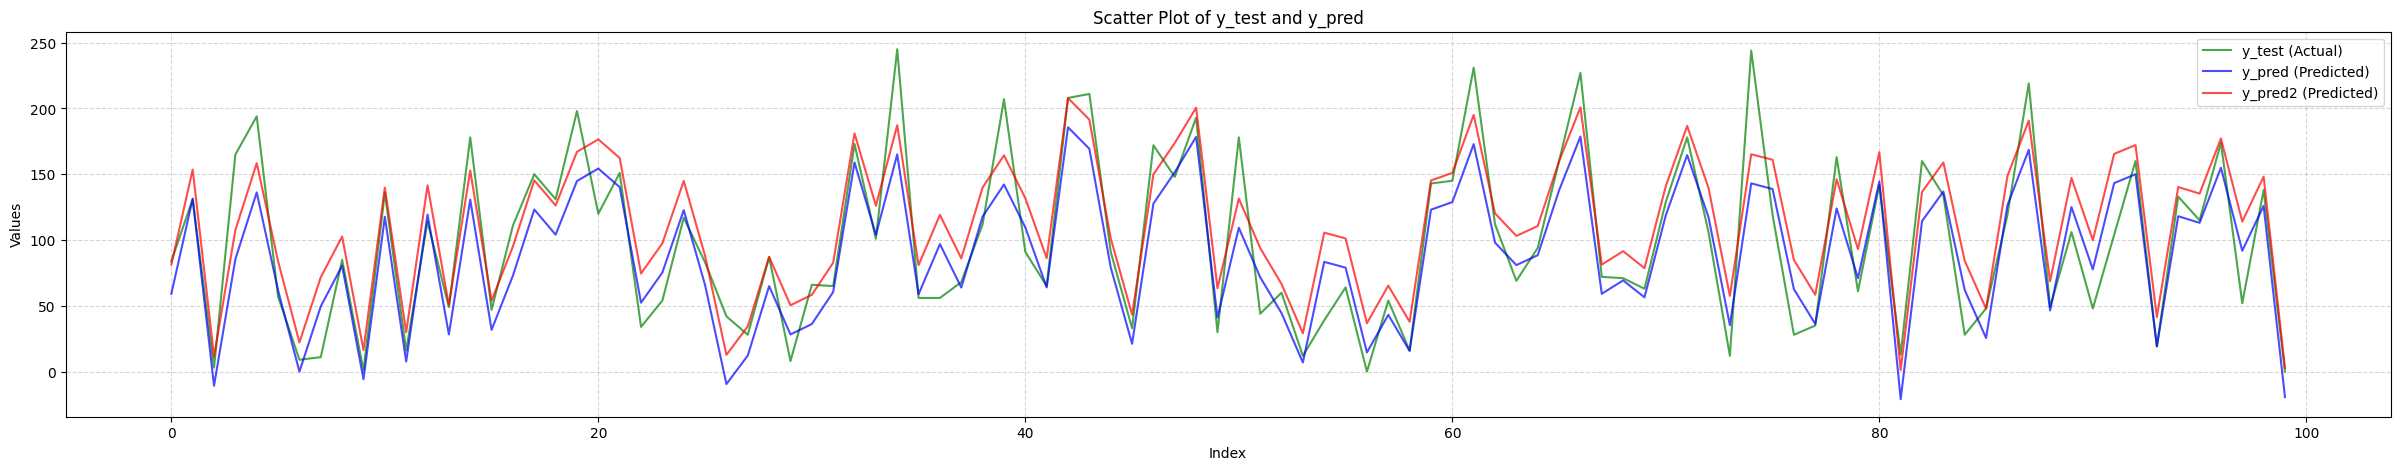

In [107]:
plt.figure(figsize=(30, 5))
size = 100
plt.plot(range(size), y_test[:size], color='green', label='y_test (Actual)', alpha=0.7)
plt.plot(range(size), y_pred1[:size], color='blue', label='y_pred (Predicted)', alpha=0.7)
plt.plot(range(size), y_pred2[:size], color='red', label='y_pred2 (Predicted)', alpha=0.7)

# Add labels, title, legend, and grid
plt.xlabel("Index")
plt.ylabel("Values")
plt.title("Scatter Plot of y_test and y_pred")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

### Test data

In [112]:
test_df = utils.load_data("CMAPSSData/test_FD001.txt")
test_y = pd.read_csv("CMAPSSData/RUL_FD001.txt", sep=" ", header=None)
test_y.drop(axis=1, columns=[1], inplace=True)
features_to_keep = ['engine_id', 'time', 'LPC_outlet_temperature', 'HPC_outlet_temperature',
                    'bypass-duct_pressure', 'Corrected_fan_speed', 'Corrected_core_speed',
                    'Bypass_Ratio', 'Bleed_Enthalpy']
test_df = test_df[features_to_keep]
features = list(test_df.columns)
features.remove('time')
features.remove('engine_id')
test_df[features] = scaler.transform(test_df[features])
# test_df_with_pctchange = pct_change(test_df, features)
test_df_with_pctchange = test_df.copy()


In [113]:

test_df_with_pctchange

,engine_id,time,LPC_outlet_temperature,HPC_outlet_temperature,bypass-duct_pressure,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy
0,1,1,0.545181,0.310661,1.0,0.220588,0.132160,0.308965,0.333333
1,1,2,0.150602,0.379551,1.0,0.264706,0.204768,0.213159,0.416667
2,1,3,0.376506,0.346632,1.0,0.220588,0.155640,0.458638,0.416667
3,1,4,0.370482,0.285154,1.0,0.250000,0.170090,0.257022,0.250000
4,1,5,0.391566,0.352082,1.0,0.220588,0.152751,0.300885,0.166667
...,...,...,...,...,...,...,...,...,...
13091,100,194,0.611446,0.619359,1.0,0.176471,0.584890,0.564063,0.500000
13092,100,195,0.605422,0.537388,1.0,0.308824,0.572350,0.485956,0.583333
13093,100,196,0.671687,0.482014,1.0,0.235294,0.605326,0.507888,0.583333
13094,100,197,0.617470,0.522128,1.0,0.294118,0.622046,0.562524,0.583333


In [114]:
max_time_df = test_df_with_pctchange.loc[test_df_with_pctchange.groupby('engine_id')['time'].idxmax()]
max_time_df

,engine_id,time,LPC_outlet_temperature,HPC_outlet_temperature,bypass-duct_pressure,Corrected_fan_speed,Corrected_core_speed,Bypass_Ratio,Bleed_Enthalpy
30,1,31,0.412651,0.221932,1.0,0.264706,0.155692,0.298192,0.416667
79,2,49,0.403614,0.339002,1.0,0.308824,0.139127,0.483263,0.250000
205,3,126,0.503012,0.407892,1.0,0.382353,0.162659,0.334744,0.583333
311,4,106,0.472892,0.512099,1.0,0.338235,0.173909,0.532897,0.583333
409,5,98,0.319277,0.412034,1.0,0.397059,0.133141,0.428242,0.500000
...,...,...,...,...,...,...,...,...,...
12545,96,97,0.328313,0.432527,1.0,0.191176,0.249252,0.331281,0.250000
12679,97,134,0.415663,0.259865,1.0,0.264706,0.286614,0.481339,0.583333
12800,98,121,0.442771,0.620667,1.0,0.308824,0.239705,0.379377,0.500000
12897,99,97,0.237952,0.304992,1.0,0.205882,0.260295,0.290112,0.250000


In [203]:
X = max_time_df.drop(['engine_id'], axis=1)
alphas = [0.1]
result = mapie_reg.predict(X, alpha=alphas)

In [204]:
def evaluate_mapie_output(result, draw_size=100):
    plt.figure(figsize=(30, 5))
    y_pred, y_intervals = result
    y_pred_min = y_intervals[:, 0, :].clip(min=0)
    y_pred_max = y_intervals[:, 1, :]
    plt.plot(range(1, draw_size + 1), test_y[:draw_size], color='gold', label='RUL (Actual)', alpha=0.7)
    plt.plot(range(1, draw_size + 1), y_pred_min[:draw_size], color='blue', label='lower RUL bound (Predicted)',
             alpha=0.7)
    plt.xlabel("Engine ID")
    plt.ylabel("RUL")
    plt.title("Scatter Plot of y_test and y_pred")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


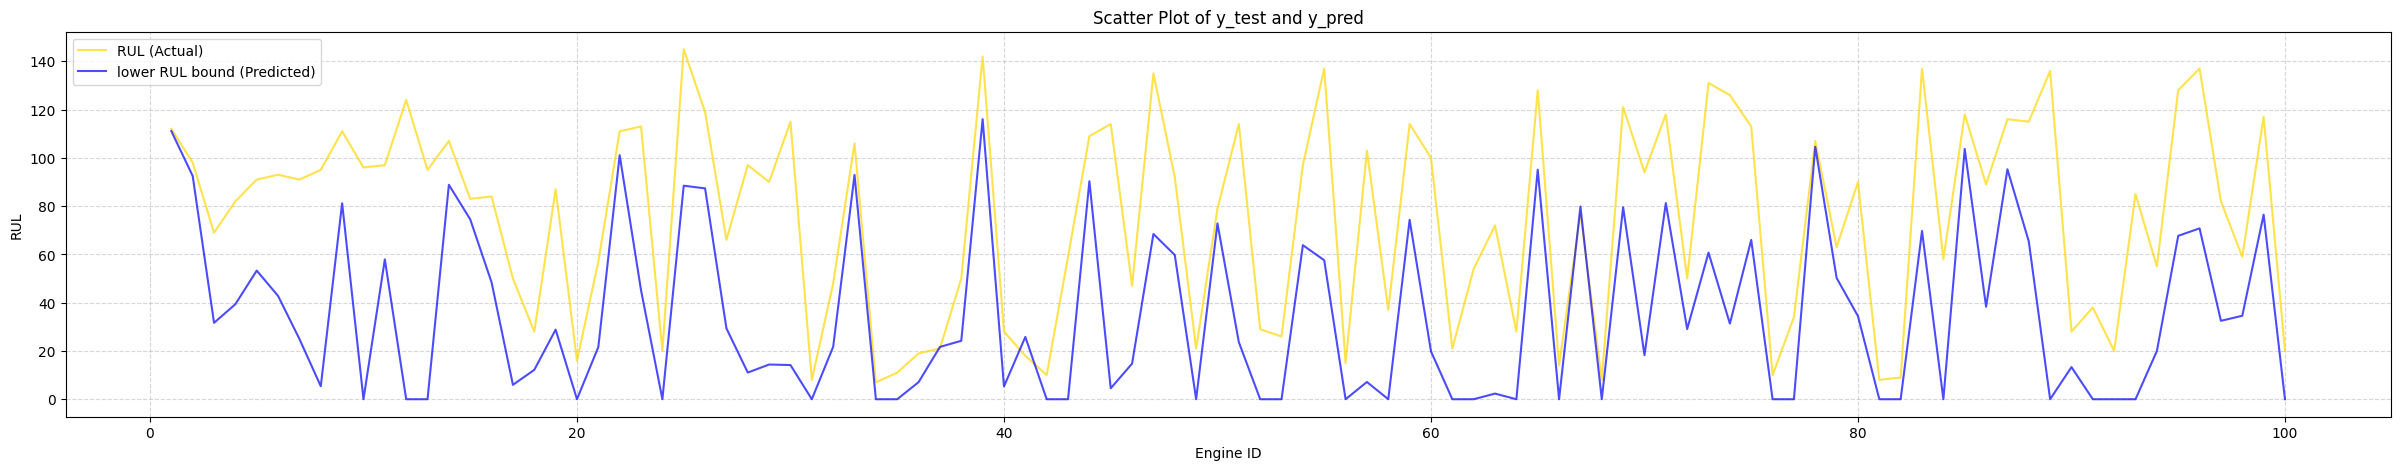

In [205]:
evaluate_mapie_output(result)

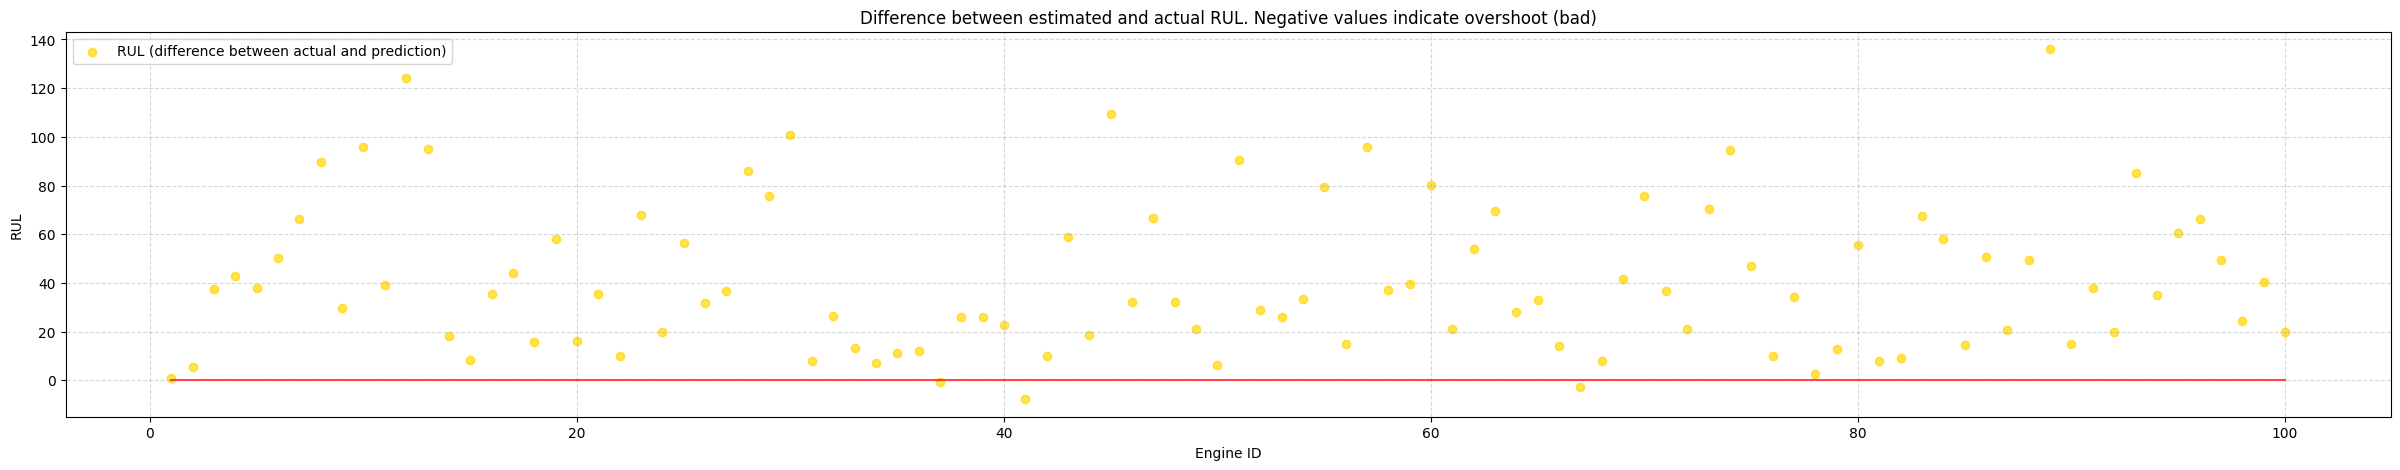

In [207]:
plt.figure(figsize=(30, 5))
y_pred, y_intervals = result
y_pred_min = y_intervals[:, 0, :].clip(min=0)
y_pred_max = y_intervals[:, 1, :]
plt.scatter(range(1, 100 + 1), test_y[:100] - y_pred_min[:100], color='gold',
            label='RUL (difference between actual and prediction)', alpha=0.7)
plt.plot(range(1, 100 + 1), y_pred_min[:100].clip(min=0, max=0), color='red', alpha=0.7)

plt.xlabel("Engine ID")
plt.ylabel("RUL")
plt.title("Difference between estimated and actual RUL. Negative values indicate overshoot (bad)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()